In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable # si nos da un error este comando es por no tenerlo instalado
#!pip install holidays
import holidays
from datetime import date, datetime

# Asunciones y Preprocesamiento
# ==============================================================================
from scipy import stats
import math
from scipy.stats import levene
import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools

pd.options.display.max_columns=None
# establecer el tamaño de nuestras figuras
plt.rcParams["figure.figsize"] = (10,8)

## Primer DF:

In [3]:
df = pd.read_csv('data/bikes.csv', index_col = 0)

In [4]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Vemos que no hay nulos ni duplicados:

In [5]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
df.duplicated().sum()

0

Renombramos y modificamos columnas con errores (dia_semana, fecha_nueva, festividad_1, estacion, año) y borramos las columnas orginales.

También limpiamos los datos de las columnas para hacerlos más legibles (temperatura,sens_térmica,humedad, viento):

In [9]:
df2 = pd.read_csv('data/bikes_limpio.csv', index_col = 0)
df2.head()

,registro,clima,temperatura,sens_termica,humedad,viento,ocasionales,registrados,total,fecha_nueva,festividad,festividad_1,año_bueno,estacion_correcta,mes_bueno,dia_semana_nuevo,no_laboral_nuevo
0,1,2,14.1,18.2,81.0,10.7,331,654,985,2018-01-01,New Year's Day,1,2018,invierno,1,0,0
1,2,2,14.9,17.7,70.0,16.7,131,670,801,2018-01-02,NaN,0,2018,invierno,1,1,1
2,3,1,8.0,9.5,44.0,16.6,120,1229,1349,2018-01-03,NaN,0,2018,invierno,1,2,1
3,4,1,8.2,10.6,59.0,10.7,108,1454,1562,2018-01-04,NaN,0,2018,invierno,1,3,1
4,5,1,9.3,11.5,44.0,12.5,82,1518,1600,2018-01-05,NaN,0,2018,invierno,1,4,1


### 2. Miramos los outliers de nuestro df y encontramos en ocasionales, viento y humedad.

En humedad y viento calculamos media y mediana y como los valores no difieren y son pocos datos, sustituimos por la media.

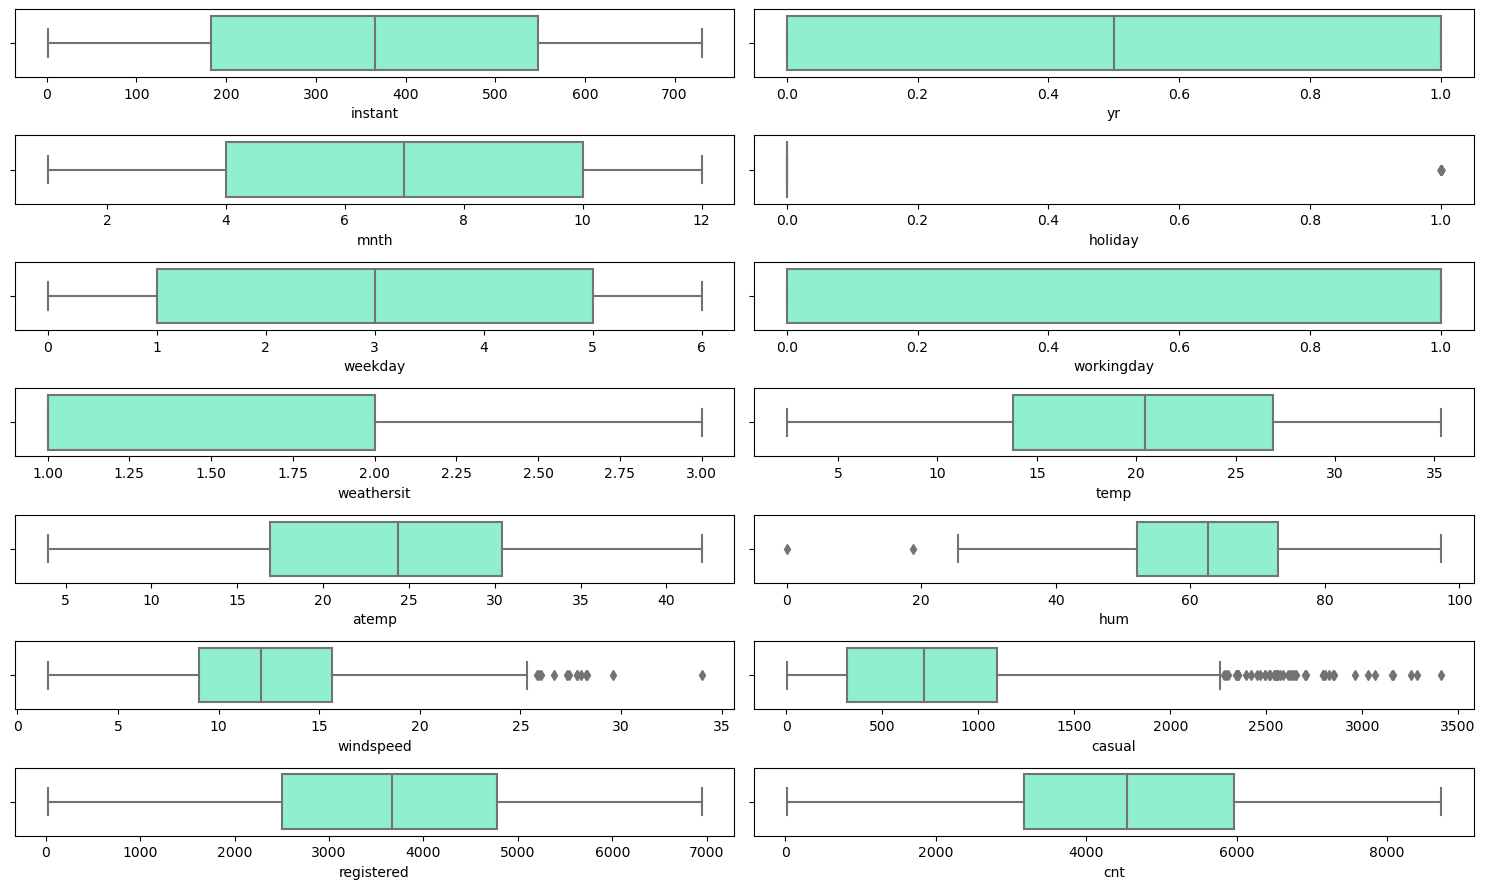

In [10]:
numericas = df.select_dtypes(include = np.number)

fig, axes = plt.subplots(7,2, figsize=(15,9))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); 

    
plt.tight_layout()
plt.show()

En el caso de ocasionales, no los eliminamos pero encontramos un patrón: las temperaturas cálidas en los meses de primavera-verano mayoritariamente.

## Observamos la correlación:

/tmp/ipykernel_20899/3248638306.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


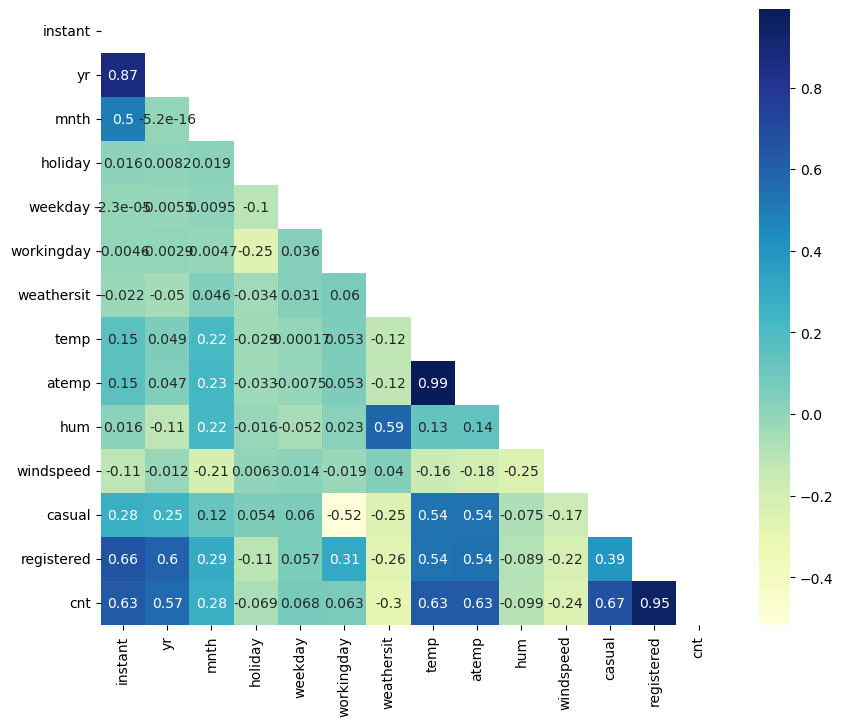

In [11]:
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

sns.heatmap(df.corr(), # calculamos la correlación. En este caso, como no estamos especificando nada la correlación será la de Pearson.
            cmap = "YlGnBu", # para especoficar el color del mapa
           annot = True, 
           mask = mask); # para sacar el valor de la correlación

Obviamente sobre los totales influyen registrados/ocasionales. **Decidimos que para  que  nos salgan resultados más precisos, lo mejor es dividir el  DF entre estas dos variables, que pasaran a ser nuestras variables respuestas en su respectivo conjunto de datos**.

Parece que la temperatura y la sensación térmica también influyen en el número de bicis alquiladas.

## Vamos  primero con el DF de registrados

In [14]:
df3 = pd.read_csv('data/bikes_registrados.csv', index_col = 0)

De las variables que tenemos registradas con tipo numérico, solo nos interesa analizar como variables numéricas: 'temperatura','sens_termica','viento' y 'humedad'.

''

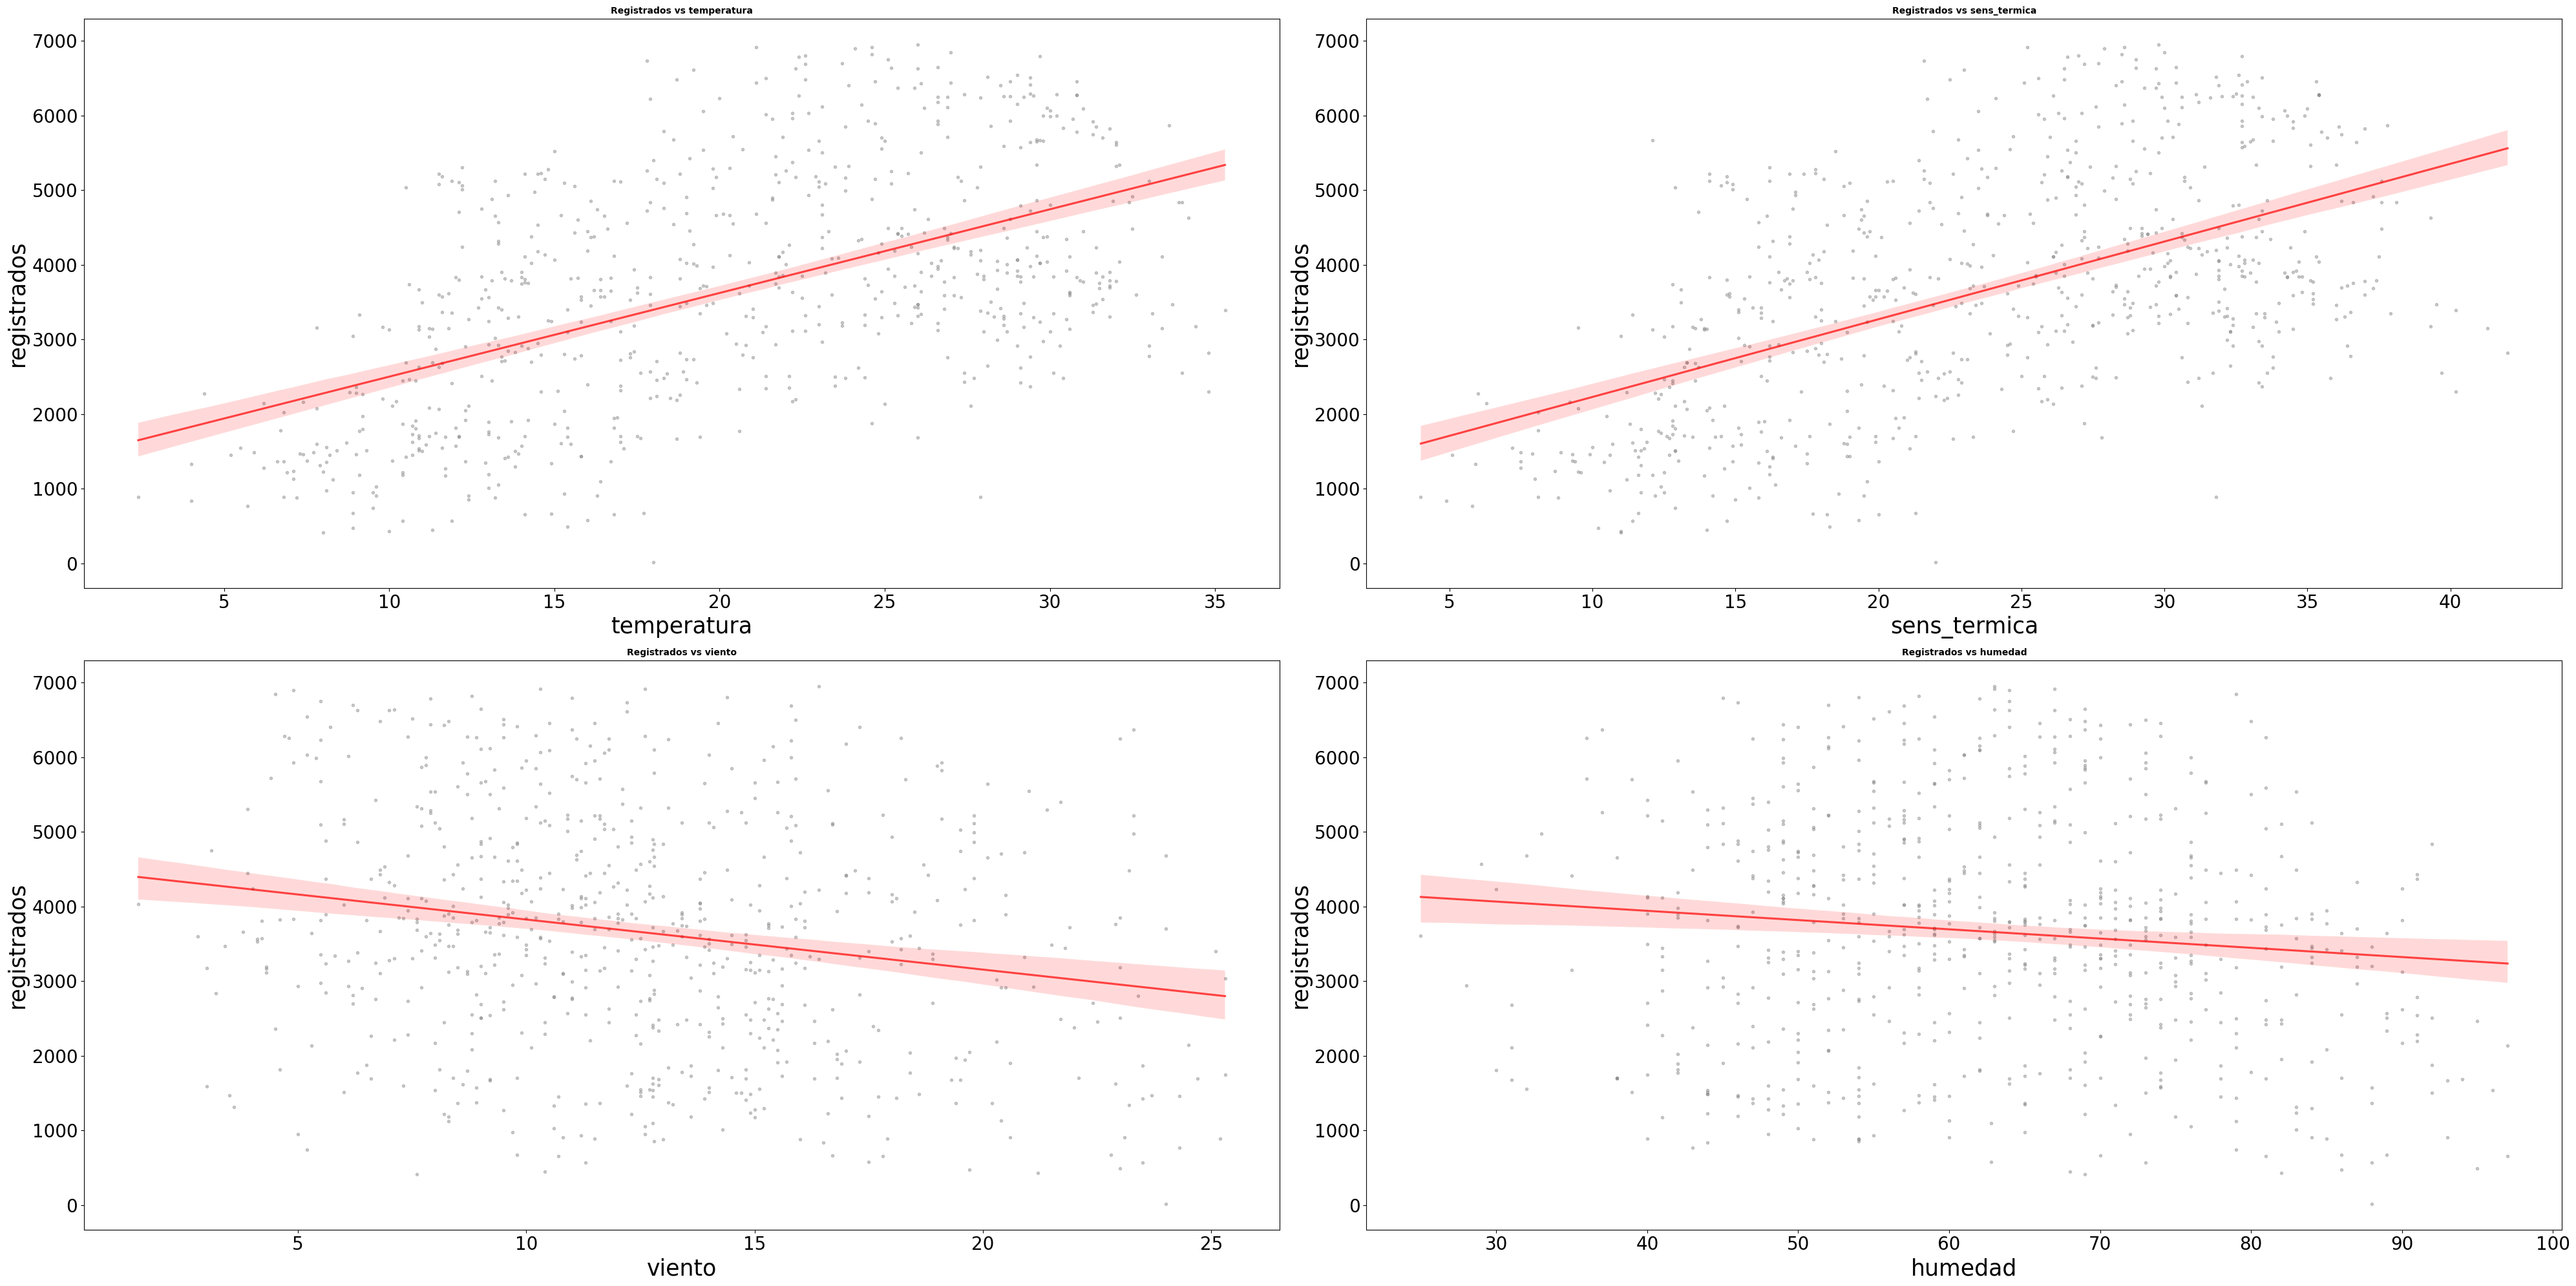

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))

axes = axes.flat

columnas_numeric = df3.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("registrados")
lista_numericas=['temperatura','sens_termica','viento', 'humedad']

for i, colum in enumerate(lista_numericas):
    sns.regplot(
        x = df3[colum], 
        y = df3["registrados"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Registrados vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "registrados", fontsize = 25)
    
fig.tight_layout()
#fig.delaxes(axes[-1])
;

Vemos que no hay mucha relación entre las variables viento y humedad con registrados, pero si vemos cierta relación con temperatura y sens_termica.

## Por último, vemos las asunciones:

### Normalidad

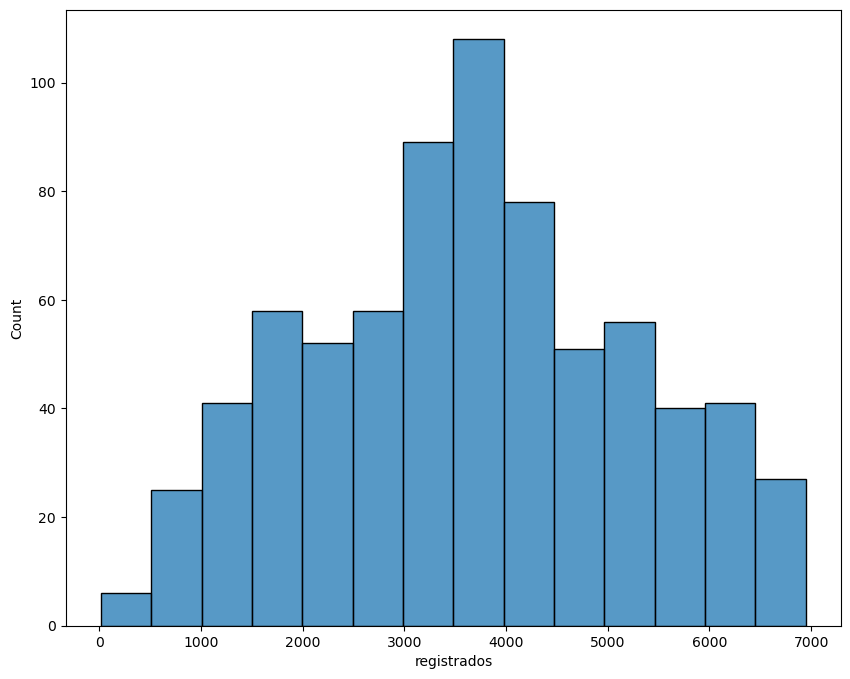

In [19]:
sns.histplot(data = df3, x = "registrados");

In [20]:
stats.shapiro(df3["registrados"])

ShapiroResult(statistic=0.9843854308128357, pvalue=5.023125027037167e-07)

Como es p-value menor de 0.05 rechzamos H0, por tanto, nuestros datos no son normales.

### Independencia

Comprobamos las relaciones utilizando el itertools, que nos devuelve este resultado:

|   |  |   |   |   |   |   |
|---|---|---|---|---|---|---|
|**Festividad**  |estacion   |mes bueno   |   |   |   |   |
|**festividad_1**   |dia_semana   |   |   |   |   |   |
|**año_bueno**   |NINGUNA   |   |   |   |   |   |   |   |
|**estación_correcta**   |mes_bueno   |   |   |   |   |   |
|**dia_semana**   |no_laboral   |   |   |   |   |   |
|**clima**   |temperatura   |humedad   |viento   |estacion_correcta   |mes_bueno   |   |
|**temperatura**   |sens_termica   |humedad   |viento   |festividad   |estacion   |mes   |
|**humedad**   |viento   |estacion_correcta   |   |   |   |   |
|**viento**   |estacion_correcta   |mes_bueno   |   |   |   |   |
|**sens_termica**   |mes_bueno   |estacion_correcta   |   |   |   |   |

Esto nos ha hecho pensar en cuáles tenemos que eliminar.

In [23]:
df3.columns

Index(['registro', 'clima', 'temperatura', 'sens_termica', 'humedad', 'viento',
       'registrados', 'fecha_nueva', 'festividad', 'festividad_1', 'año_bueno',
       'estacion_correcta', 'mes_bueno', 'dia_semana_nuevo',
       'no_laboral_nuevo'],
      dtype='object')

### Homogeneidad 

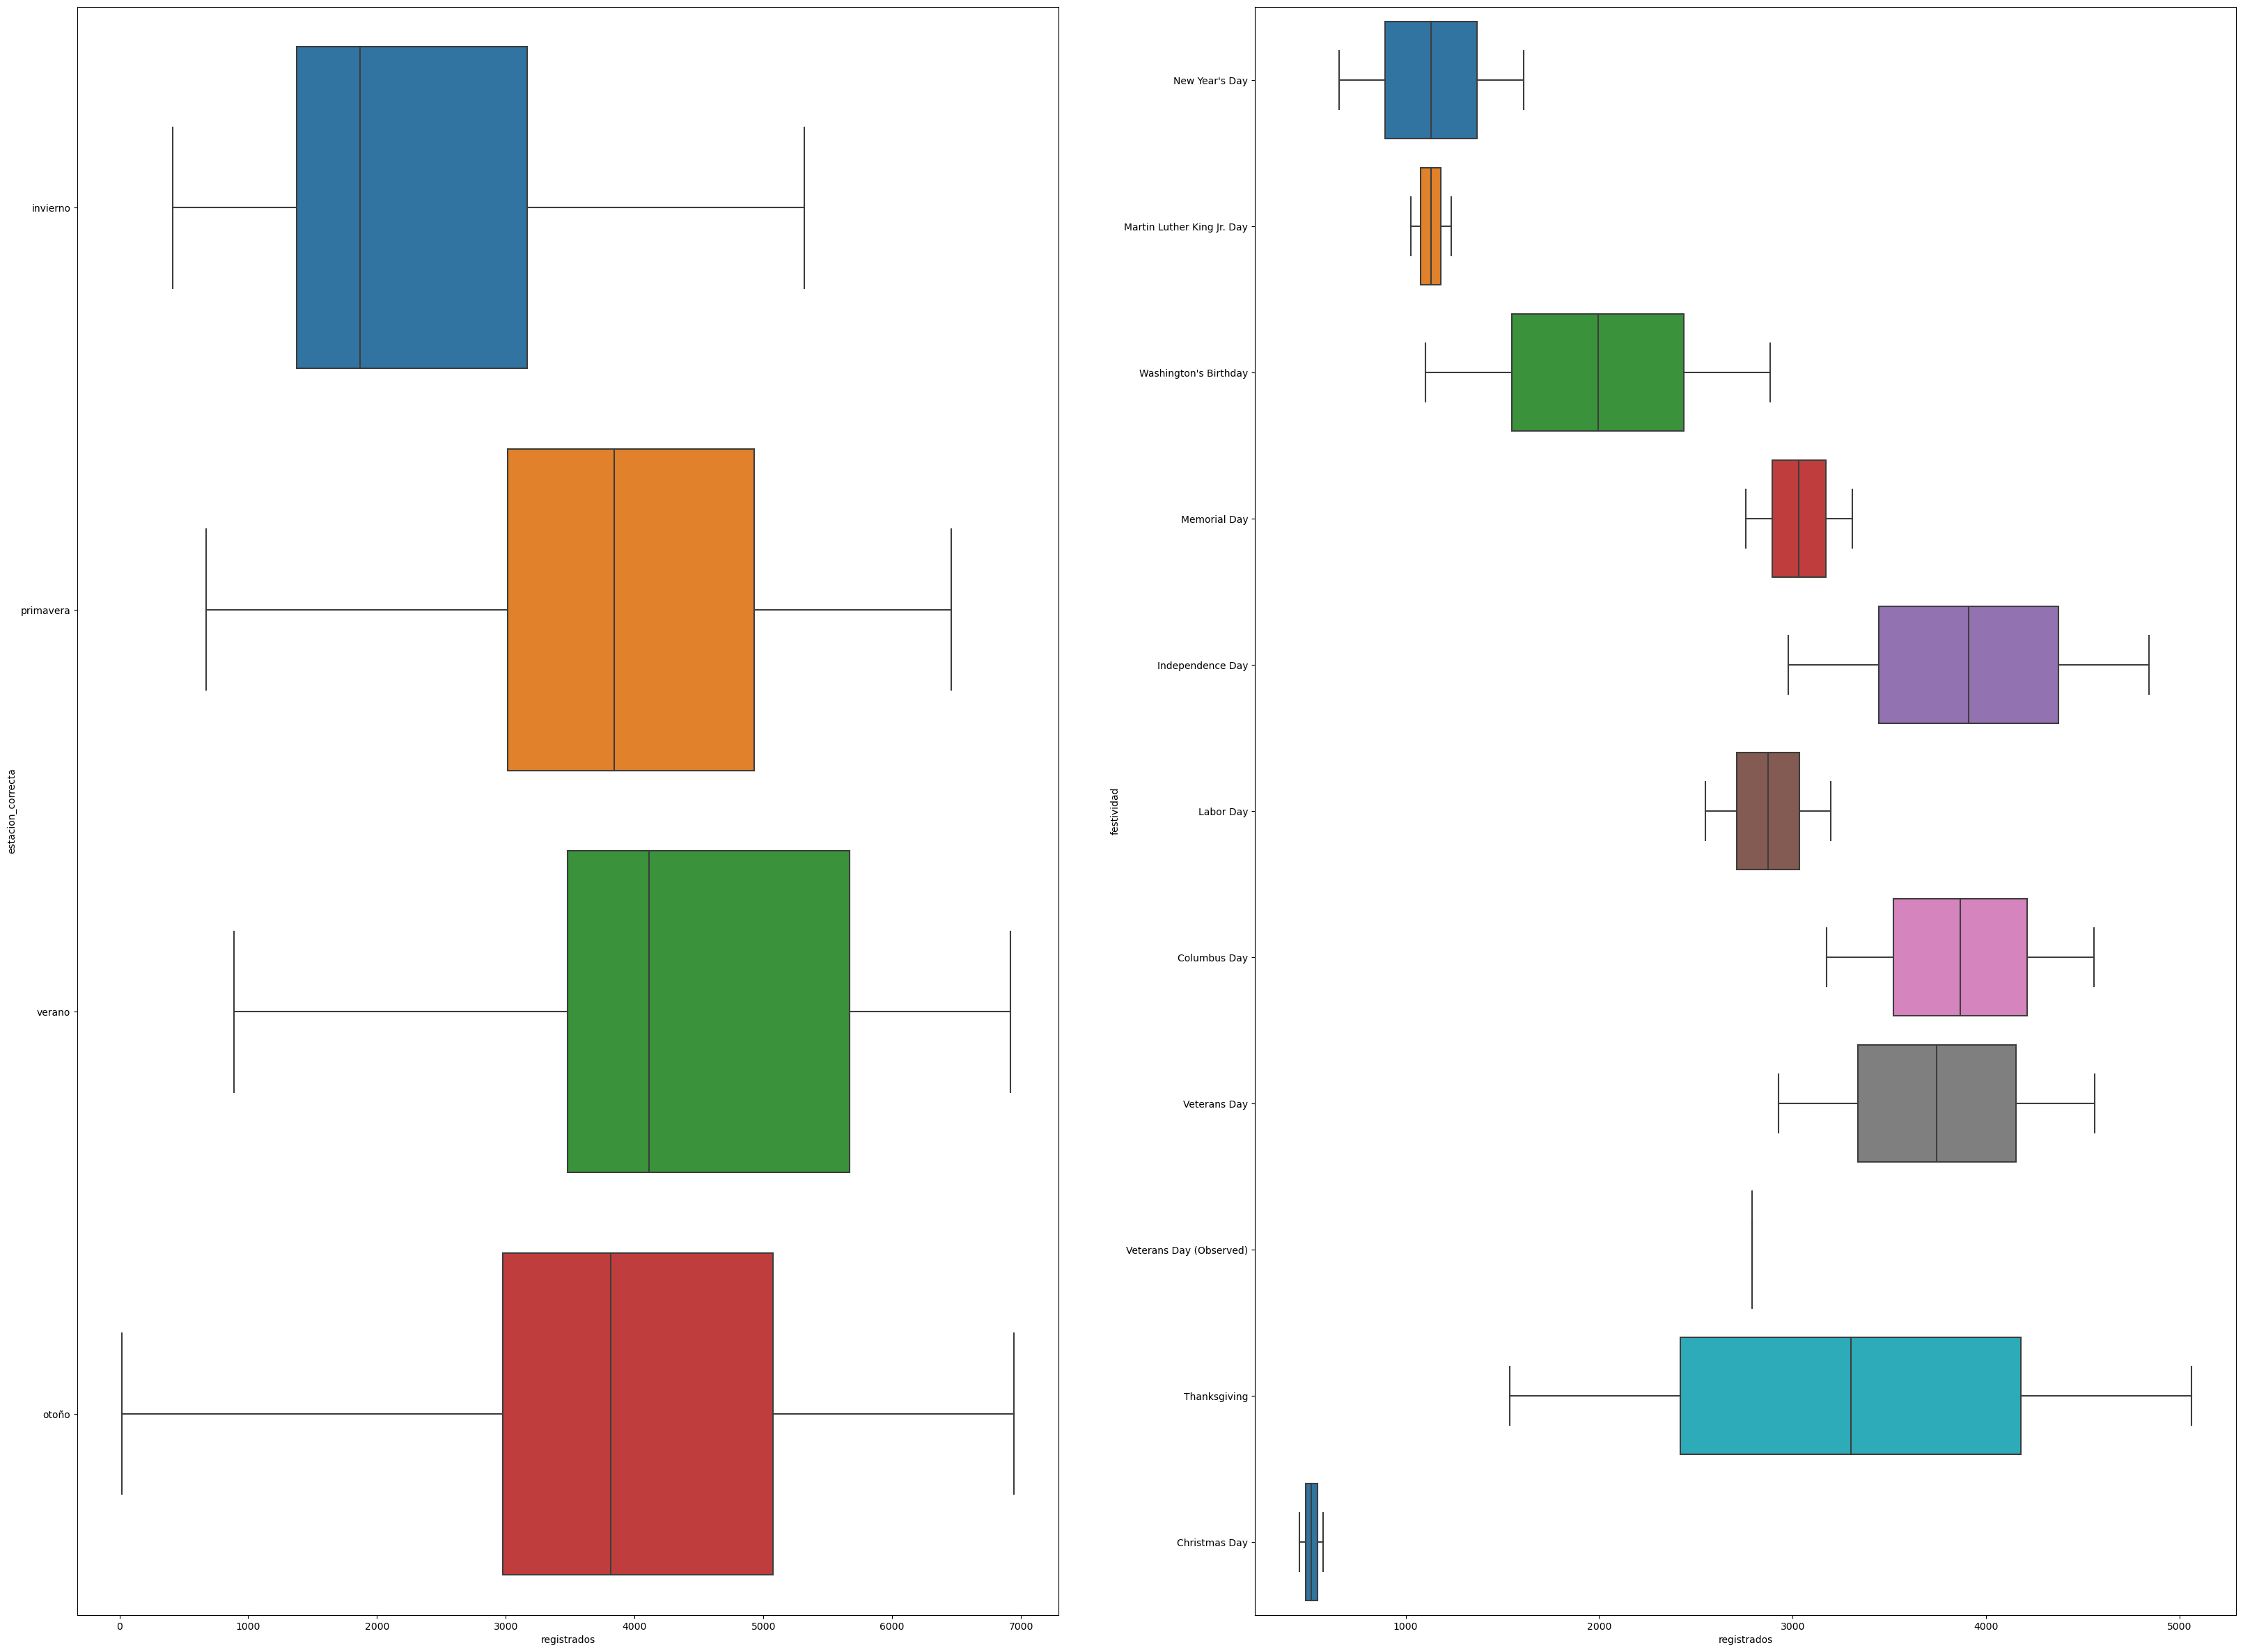

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (40, 30))

axes = axes.flat

columnas_cat = ['estacion_correcta', 'festividad']
for i, colum in enumerate(columnas_cat):
    sns.boxplot(
    x       = 'registrados',
    y       = colum,
    data    = df3,
    palette = 'tab10',
    ax      = axes[i]
    )

Hemos hecho el test de levene para la columna de 'festividad', que devuelve un p-value de 0.0, no cumple asunción.

#  Pasos siguientes

- Eliminar varibles redundantes (observando test de independencia)
- Independencia para variables continuas (Pearson y Spearman)
- Seguir comprobando homogeneidad
- Normalización, Estandarización
- Encoding de 'estaciones' y pensar en un psoible encoding para 'festividad'
